In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder 


rc = {
    "axes.facecolor": "#FFFFFF",       
    "figure.facecolor": "#FFFFFF",
    "axes.edgecolor": "#000000",
    "grid.color": "#CCCCCC",
    "font.family": "malgun gothic",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc = rc)
plt.rc('axes', unicode_minus = False)

# **공연 수준을 정의해야 한다**

이 전 군집분석 프로토타입에서 공연의 가장 비싼 등급의 가격에 따라 다른 군집이 생성되는 모습을 발견 할 수 있었다.

그렇다면 적절한 그룹핑을 할 기준이 필요하다

In [2]:
reservation_table = pd.read_parquet("C:/Users/whileduck/Desktop/Github/Concert-Hall-Price-Model/data/reservation_table.parquet")

In [3]:
display(reservation_table.head(3))
print(reservation_table.shape)

,전체공연시간,좌석 오픈 여부 sum,예매여부 sum,원가격추정 amin,원가격추정 mean,원가격추정 amax,거래까지걸린시간_시간 amin,거래까지걸린시간_시간 mean,거래까지걸린시간_시간 amax,공연 예매율,...,콘서트홀클래식_누적검색량,예술의전당클래식_누적검색량,서울클래식_누적검색량,연도,월,연 월,일,시간,요일,총_누적_검색량
0,2018-11-25 17:00:00,10020,6216,0,60700.598802,100000,106.000000,370.685736,592.550000,0.620359,...,1000.0,0.0,50.0,2018,11,2018-11-01,25,17,6,1050.0
1,2018-12-08 17:00:00,10020,8636,0,51369.261477,100000,131.566667,466.007264,880.766667,0.861876,...,980.0,0.0,60.0,2018,12,2018-12-01,8,17,5,1040.0
2,2019-01-11 20:00:00,10020,6368,0,90982.035928,140000,-901.983333,-7.323775,691.650000,0.635529,...,1180.0,0.0,50.0,2019,1,2019-01-01,11,20,4,1230.0


(151, 26)


In [4]:
cols = ['원가격추정 amax', '공연 예매율'] # 공연의 분류를 두 가지 변수를 이용해 분류해보자 

example = reservation_table[cols]

display(example.head())
print(example.shape)

,원가격추정 amax,공연 예매율
0,100000,0.620359
1,100000,0.861876
2,140000,0.635529
3,150000,0.858283
4,50000,0.475848


(151, 2)


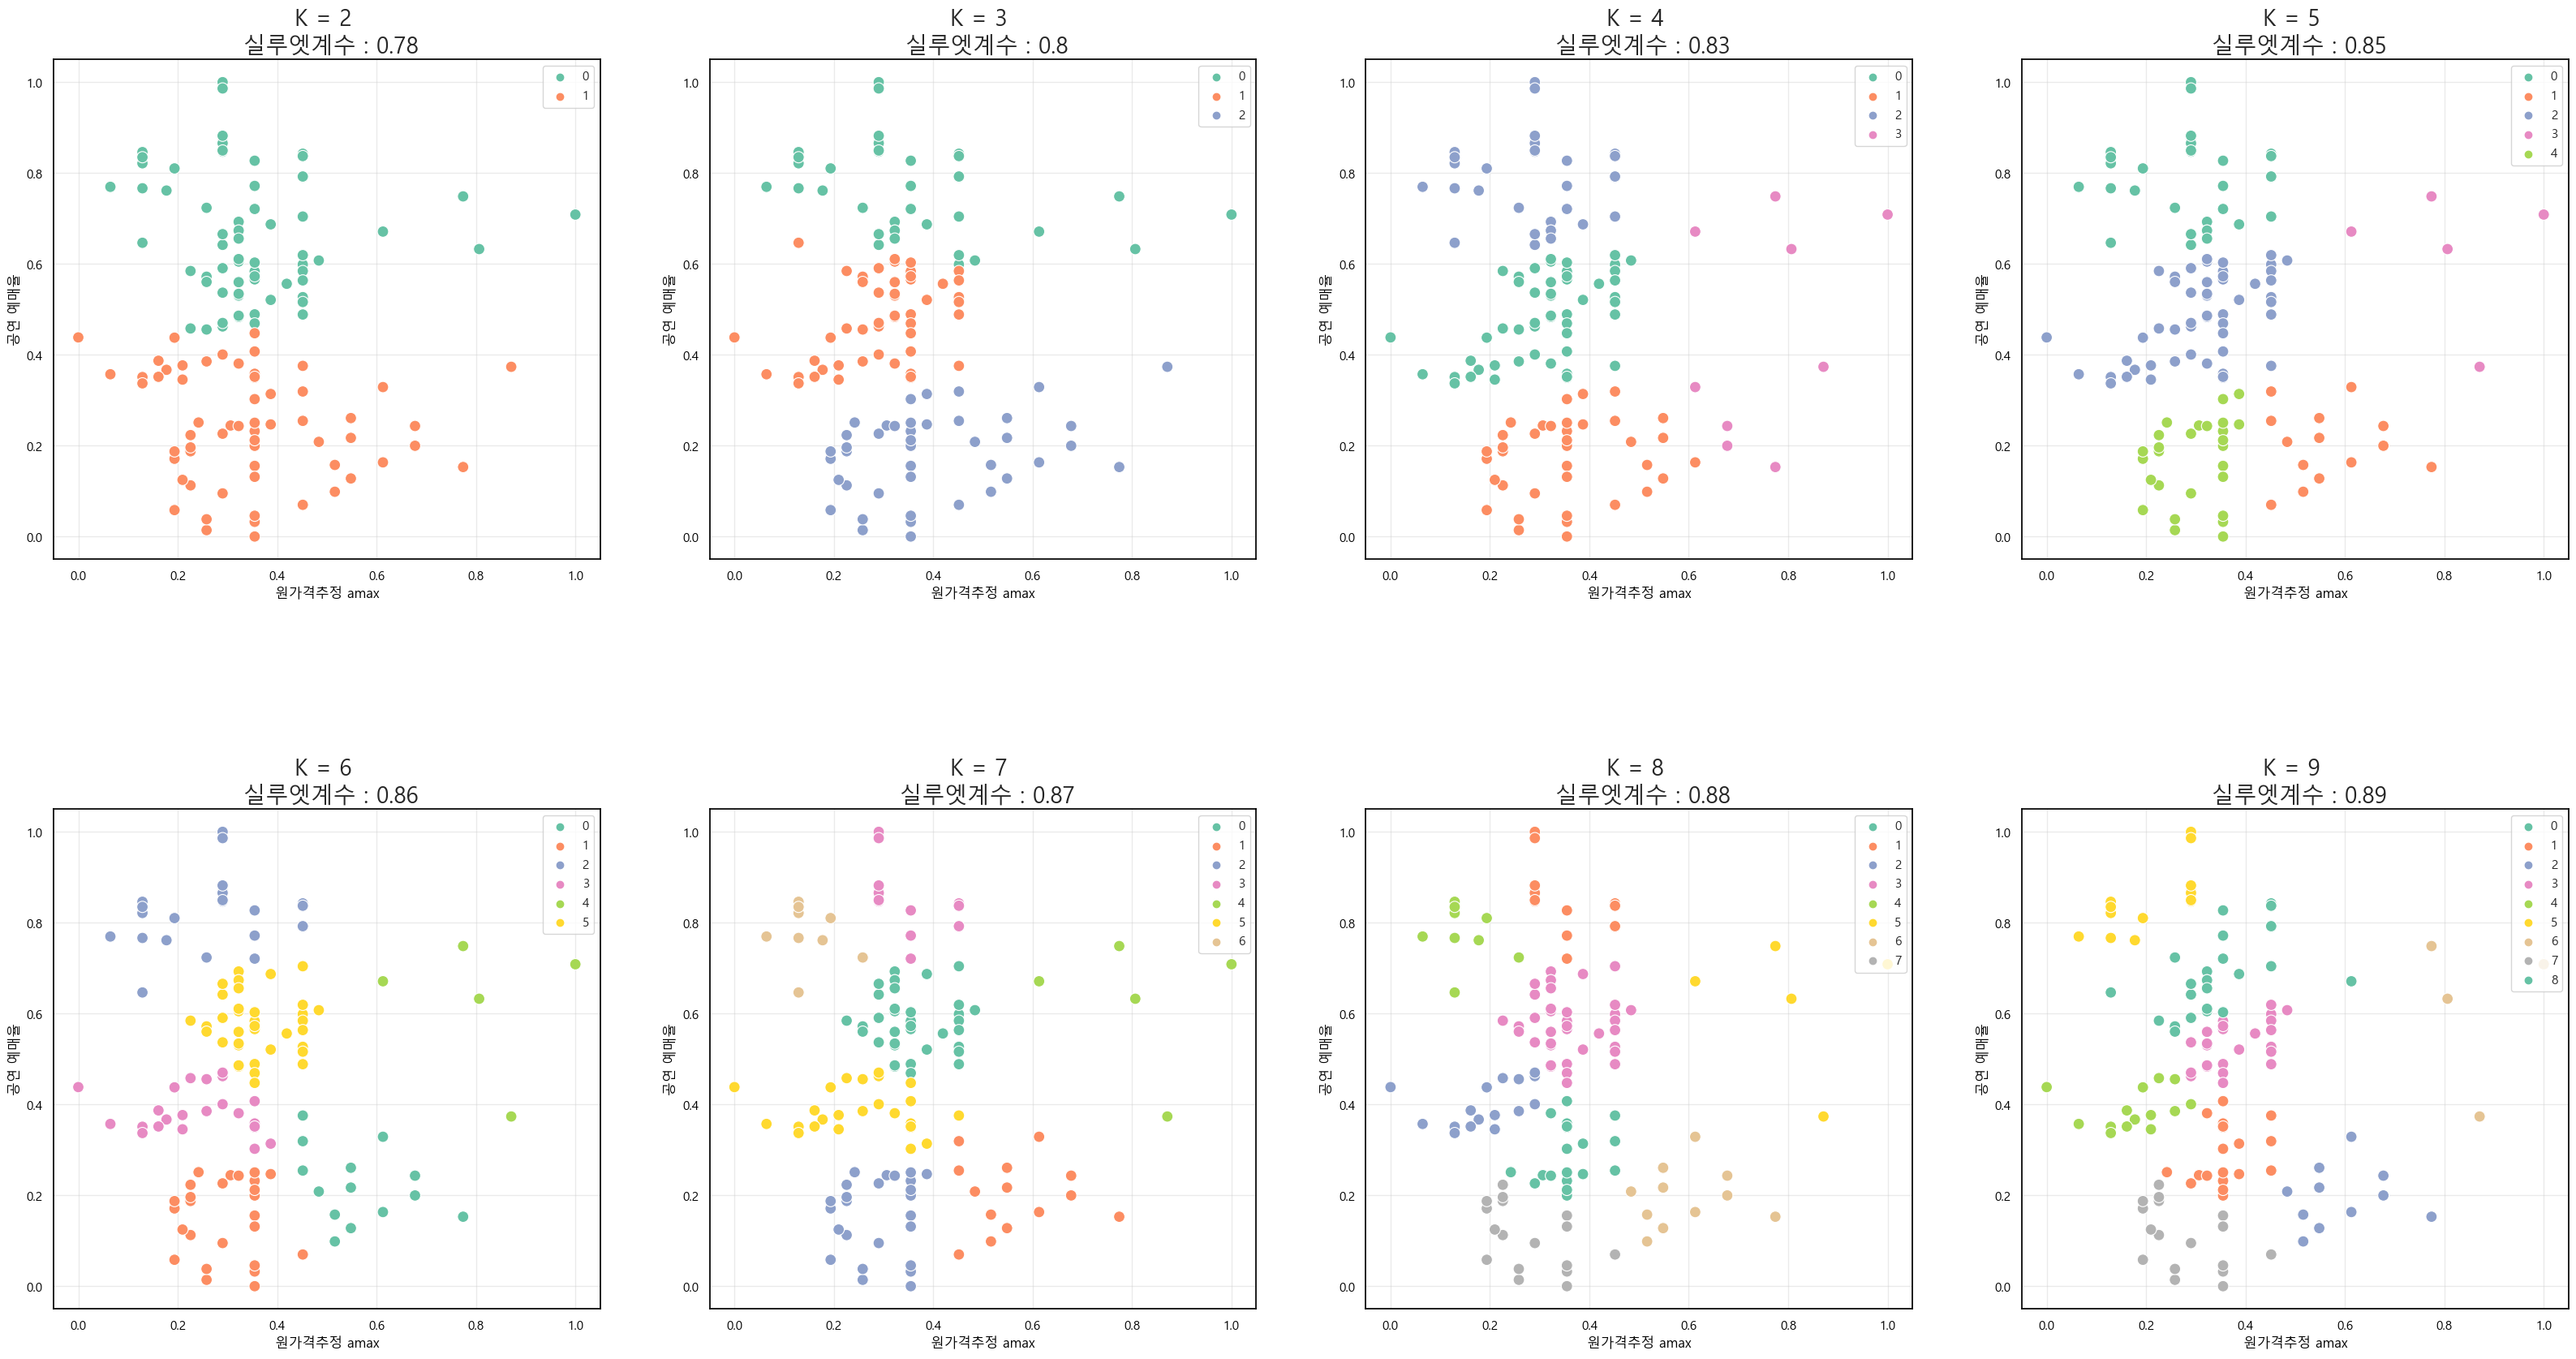

In [7]:
fig,ax = plt.subplots(figsize = (40,20), ncols = 4, nrows = 2)

ax = ax.flatten()
fig.subplots_adjust(hspace = 0.5)

scaler = MinMaxScaler()

graph_df = example[example['공연 예매율'] > 0.2].copy()

for idx,k in enumerate(range(2,9 + 1)):
    
    model = KMeans(n_clusters = k)
    
    scaled_df = pd.DataFrame(scaler.fit_transform(graph_df.iloc[:,:2]) ,columns = ['원가격추정 amax', '공연 예매율'])
    
    model.fit(scaled_df)
    scaled_df['라벨'] = model.labels_
    sil_score = silhouette_score(scaled_df,model.labels_)
    
    
    sns.scatterplot(
        data = scaled_df,
        x = '원가격추정 amax',
        y = '공연 예매율',
        hue = '라벨',
        palette = 'Set2',
        s = 100,
        ax = ax[idx]
    )
    
    ax[idx].set_title(f'K = {k} \n 실루엣계수 : {round(sil_score,2)}', fontsize = 20)
    ax[idx].legend(loc = 'upper right')

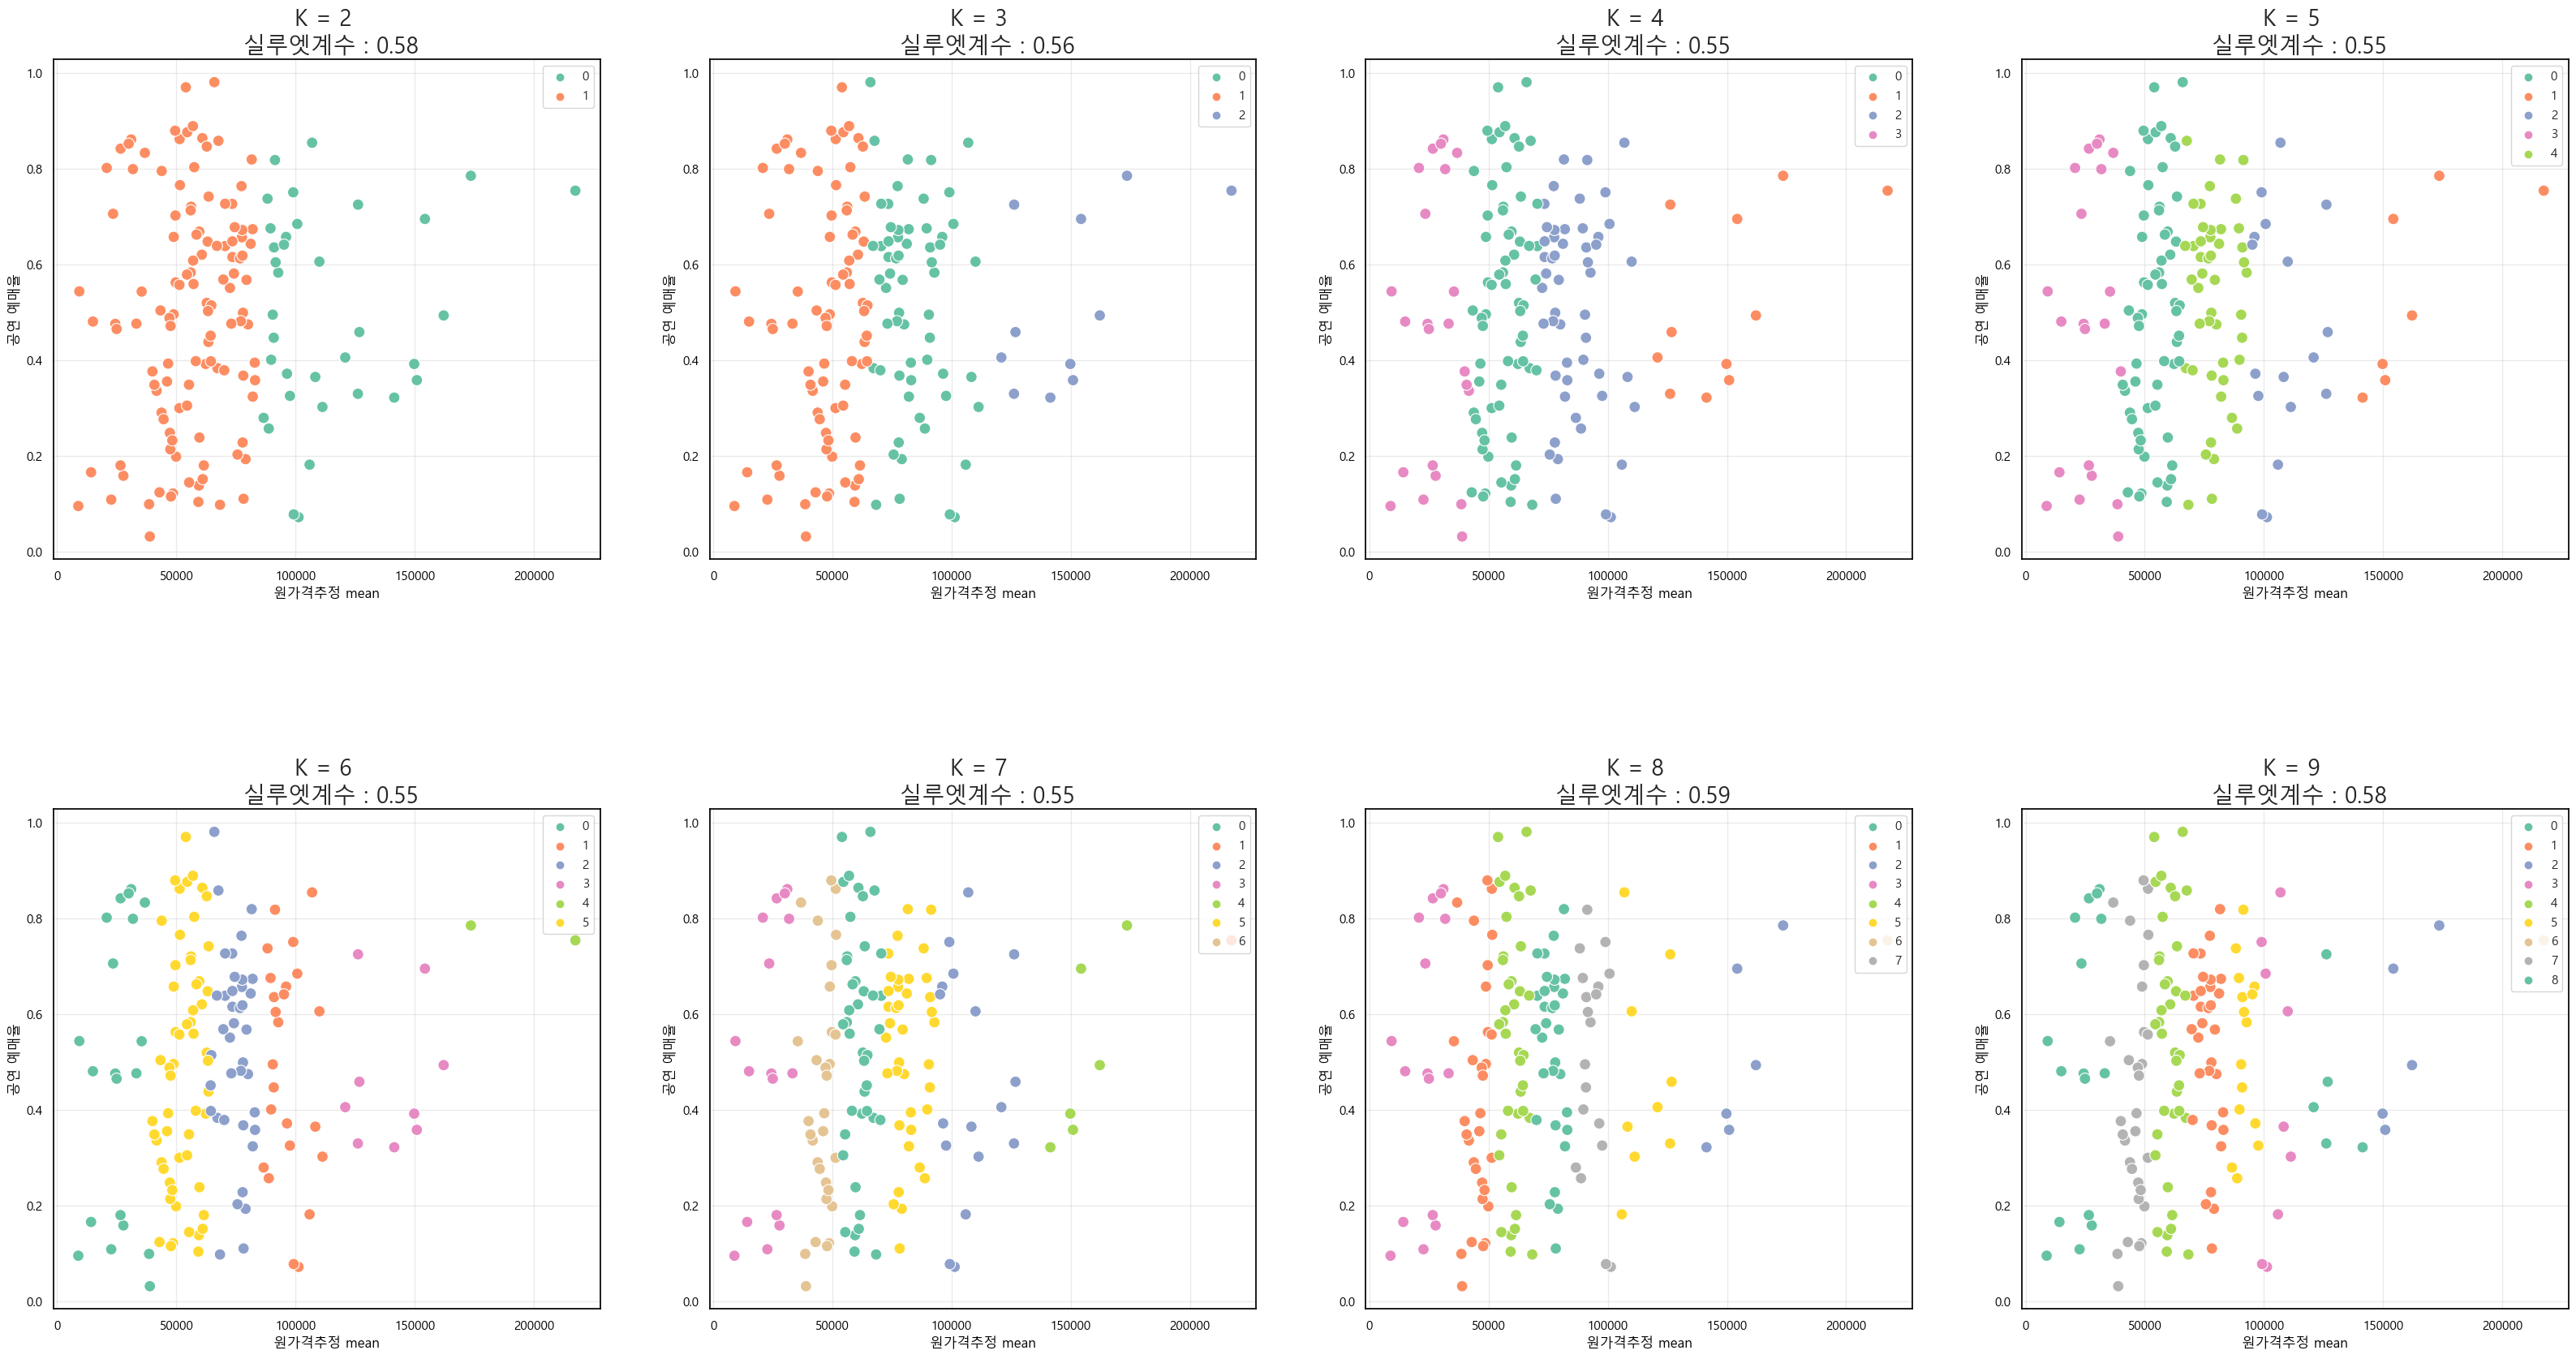

In [14]:
fig,ax = plt.subplots(figsize = (40,20), ncols = 4, nrows = 2)

ax = ax.flatten()
fig.subplots_adjust(hspace = 0.5)

scaler = MinMaxScaler()
cols = ['원가격추정 mean', '공연 예매율'] # 공연의 분류를 두 가지 변수를 이용해 분류해보자 

example = reservation_table[cols]

for idx,k in enumerate(range(2,9 + 1)):
        
    graph_df = example[['원가격추정 mean', '공연 예매율']].copy() 
    model = KMeans(n_clusters = k)
    
    # graph_df = pd.DataFrame(scaler.fit_transform(graph_df.iloc[:,:2]) ,columns = ['원가격추정 mean', '공연 예매율'])
    
    model.fit(graph_df)
    graph_df['라벨'] = model.labels_
    sil_score = silhouette_score(graph_df,model.labels_)
    
    
    sns.scatterplot(
        data = graph_df,
        x = '원가격추정 mean',
        y = '공연 예매율',
        hue = '라벨',
        palette = 'Set2',
        s = 100,
        ax = ax[idx]
    )
    
    ax[idx].set_title(f'K = {k} \n 실루엣계수 : {round(sil_score,2)}', fontsize = 20)
    ax[idx].legend(loc = 'upper right')

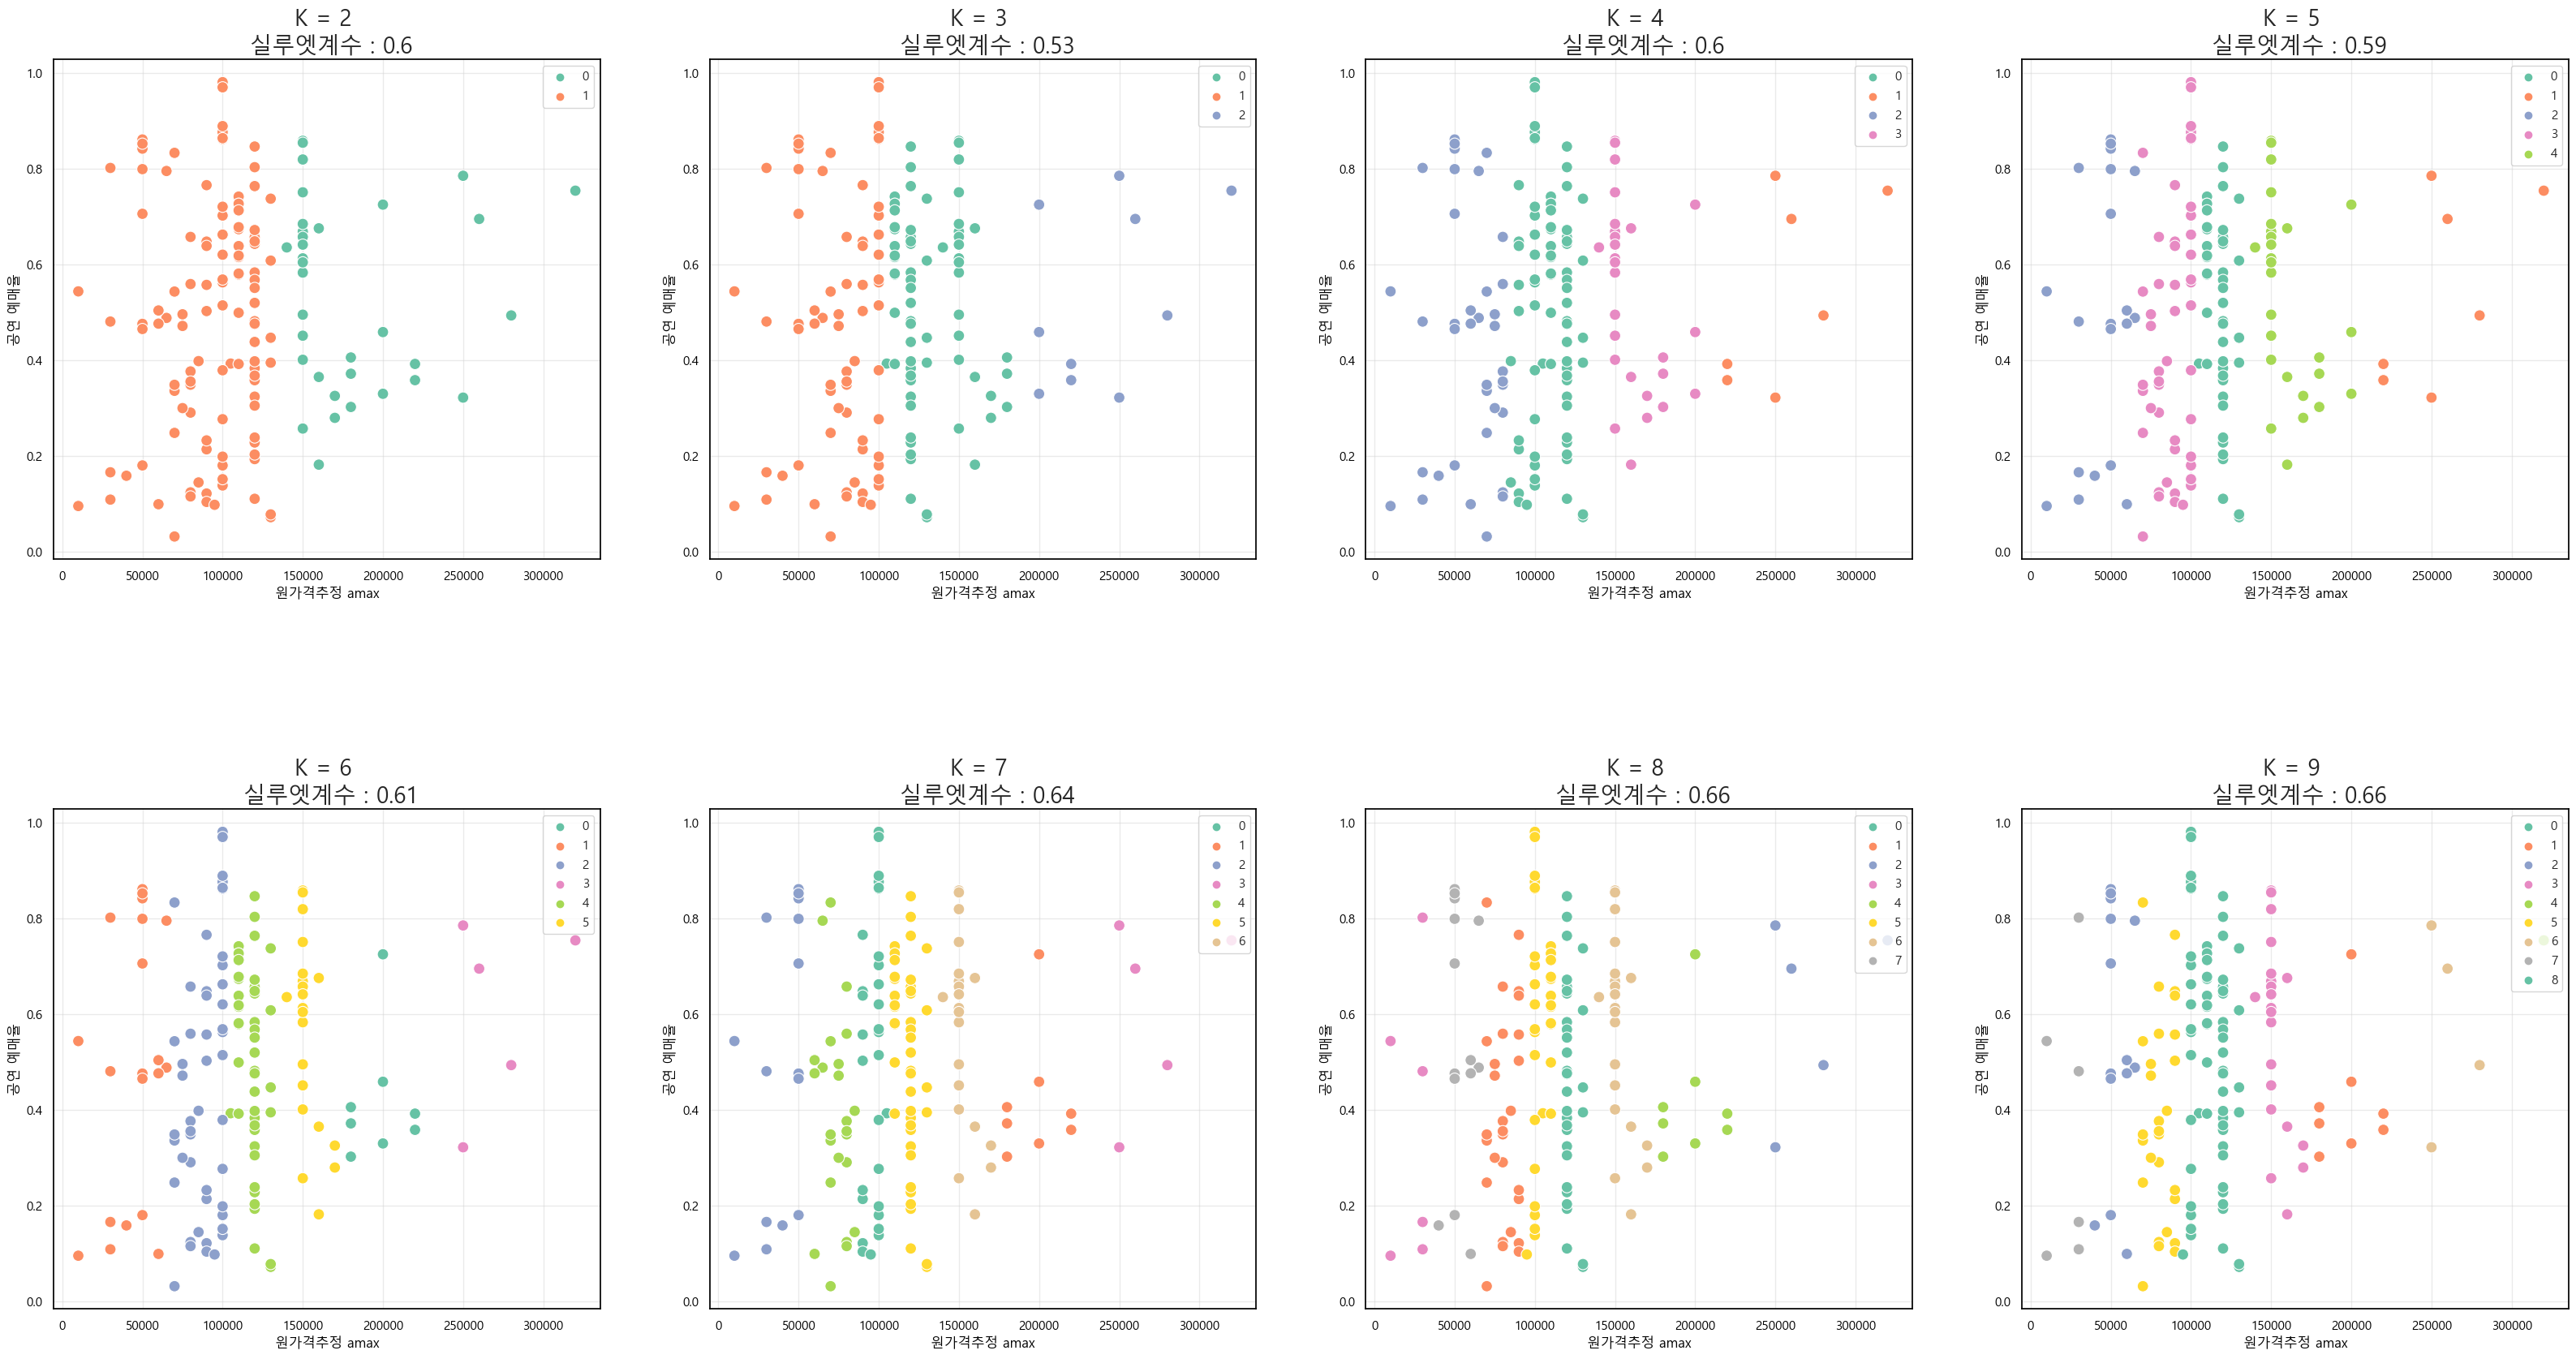

In [16]:
fig,ax = plt.subplots(figsize = (40,20), ncols = 4, nrows = 2)

ax = ax.flatten()
fig.subplots_adjust(hspace = 0.5)

scaler = MinMaxScaler()
cols = ['원가격추정 amax', '공연 예매율'] # 공연의 분류를 두 가지 변수를 이용해 분류해보자 

example = reservation_table[cols]

for idx,k in enumerate(range(2,9 + 1)):
        
    graph_df = example[['원가격추정 amax', '공연 예매율']].copy() 
    model = KMeans(n_clusters = k)
    
    # graph_df = pd.DataFrame(scaler.fit_transform(graph_df.iloc[:,:2]) ,columns = ['원가격추정 mean', '공연 예매율'])
    
    model.fit(graph_df)
    graph_df['라벨'] = model.labels_
    sil_score = silhouette_score(graph_df,model.labels_)
    
    
    sns.scatterplot(
        data = graph_df,
        x = '원가격추정 amax',
        y = '공연 예매율',
        hue = '라벨',
        palette = 'Set2',
        s = 100,
        ax = ax[idx]
    )
    
    ax[idx].set_title(f'K = {k} \n 실루엣계수 : {round(sil_score,2)}', fontsize = 20)
    ax[idx].legend(loc = 'upper right')